## Data Processing
This file focuses on processing the ERA5 NetCDF data downloaded from the Climate Data Store (CDS). The main tasks include reading the NetCDF files, extracting relevant variables, and transforming the data into a more usable format for analysis. It will also process the data from ESA CCI and prepare it for further analysis.
Within this file also further data sets will be pre-processed for analysis. But as of now only ERA5 and ESA CCI data sets are included.

#### First step
Within the first step all necessary libraries will be imported.

In [1]:
from IPython.core.display import HTML
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import netCDF4

#### Second step
In the second step the datasets will be opened and the relevant variables will be extracted.

In [26]:
## Input file paths
era5_file_path = "../data/era5/era5_1984_2020_5degree_zipped.nc"
esa_cci_file_path = '../data/esa/ESACCI-WATERVAPOUR-L3S-LP-MERGED-MZM-5deg-1985-2019_v3.3.nc'

## Open files as netCDF4
nt_thesis = 444
data_era5 = netCDF4.Dataset(era5_file_path)
data_cci = netCDF4.Dataset(esa_cci_file_path)

## Print dataset information
print(data_era5.variables.keys())
print(data_cci.variables.keys())

## Extract basic variables from datasets
### Times
time_era5 = np.array(data_era5['valid_time'][:nt_thesis])
time_cci = np.array(data_cci['time'][:nt_thesis])
### Latitudes
latitude_era5 = np.array(data_era5['latitude'][:])
latitude_cci = np.array(data_cci['lat'][:])
### Pressure Levels
pressure_levels_era5 = np.array(data_era5['pressure_level'][:])
pressure_levels_cci = np.array(data_cci['plev'][:])

dict_keys(['number', 'valid_time', 'pressure_level', 'latitude', 'longitude', 'expver', 'q', 't', 'u', 'v'])
dict_keys(['lat', 'plev', 'time', 'lat_bnds', 'time_bnds', 'zmh2o', 'zmh2o_std', 'zmh2o_err', 'zmh2o_nr', 'quality_flag'])


In [27]:
## Extract relevant h2o values from cci dataset
h2o_cci = np.array(data_cci['zmh2o'][:nt_thesis])
h2o_err_cci = np.array(data_cci['zmh2o_err'][:nt_thesis])
h2o_std_cci = np.array(data_cci['zmh2o_std'][:nt_thesis])
h2on_cci = np.array(data_cci['zmh2o_nr'][:nt_thesis])

In [28]:
## Check available pressure levels in datasets
print(pressure_levels_era5[4])
print(pressure_levels_cci[10])

h2o_cci.shape

70.0
70.0


(420, 28, 36)

In [29]:
# Select the values on 70 hPa as it is quite close to the original by Nowack et al. (2023), who did select 68 hPa
plev_era5 = 4
plev_cci = 10

h2o_cci = h2o_cci[:,plev_cci,:]
h2o_err_cci = h2o_err_cci[:,plev_cci,:]
h2o_std_cci = h2o_std_cci[:,plev_cci,:]
h2on_cci = h2on_cci[:,plev_cci,:]

# Cut out mls and evaluation periods
mlsind = np.array([248,443])
mls_h2o_cci = h2o_cci[mlsind[0]:mlsind[1],:]
mls_h2o_err_cci = h2o_err_cci[mlsind[0]:mlsind[1],:]
mls_h2o_std_cci = h2o_std_cci[mlsind[0]:mlsind[1],:]
mls_h2on_cci = h2on_cci[mlsind[0]:mlsind[1],:]
## Evaluation period
eval_ind = np.array([0,246])
eval_h2o_cci = h2o_cci[eval_ind[0]:eval_ind[1],:]
eval_h2o_err_cci = h2o_err_cci[eval_ind[0]:eval_ind[1],:]
eval_h2o_std_cci = h2o_std_cci[eval_ind[0]:eval_ind[1],:]
eval_h2on_cci = h2on_cci[eval_ind[0]:eval_ind[1],:]



In [33]:
# get only relevant data which is to be predicted
wlat = np.array(np.where((latitude_cci >= -30) & (latitude_cci <= 30))).flatten()  # We only want to predict the values 30 ° around the equator



# Create a mask where data is available
mask = h2o_cci / h2o_cci    # Setting 1, where data is available
mask[np.isnan(mask)] = 0.   # Setting 0, where no data is available

# Getting all latitudes of interest
lat30 = latitude_cci[wlat]
print(wlat, 'lat indices')

## Reshape
h2o_cci_tmp = h2o_cci[:,wlat].reshape(len(time_cci),len(lat30))
h2o_err_cci_tmp = h2o_cci_tmp.reshape(len(time_cci),len(lat30))
mask_tmp = h2o_cci_tmp / h2o_cci_tmp

## Replace NaNs for calculations
h2o_cci_tmp[np.isnan(h2o_cci_tmp)] = 0.
h2o_err_cci_tmp[np.isnan(h2o_err_cci_tmp)] = 0.

# Nowack et al. (2023) did calculate the error on the SWOOSH data. This step is skipped in this processor, as there is no need to do so. The reason behind this is, that the error and standard deviation is already part of the provided dataset by ESA CCI

# Latitudes have to be weighted to account for different size of grids
weilat = np.cos(lat30/180*np.pi)
# We now want to integrate over the latitudes of interest, in order to have a singular value for each latitude
h2o30_cci = np.zeros(len(time_cci))
h2o30_err_cci = np.zeros(len(time_cci))
h2o30_std_cci = np.zeros(len(time_cci))

## Calculate weighted averages
for tt in range(len(time_cci)):
    if np.sum(weilat*mask_tmp[tt,:]) != 0.:
        h2o30_cci[tt] = np.sum(weilat*mask_tmp[tt,:]/(np.sum(weilat*mask_tmp[tt,:]))*h2o_cci_tmp[tt,:])
        h2o30_err_cci = np.sum(weilat*mask_tmp[tt,:]/(np.sum(weilat*mask_tmp[tt,:]))*h2o_err_cci_tmp[tt,:])

## Place NaNs back in (for plotting)
h2o30_cci[np.where(h2o30_cci == 0)] = float("NaN")



[12 13 14 15 16 17 18 19 20 21 22 23] lat indices


### Plotting the first results
We have now successfully transformed the ESA CCI data into a format we can use for ridge regression. We now want to look at the data to get the first insights

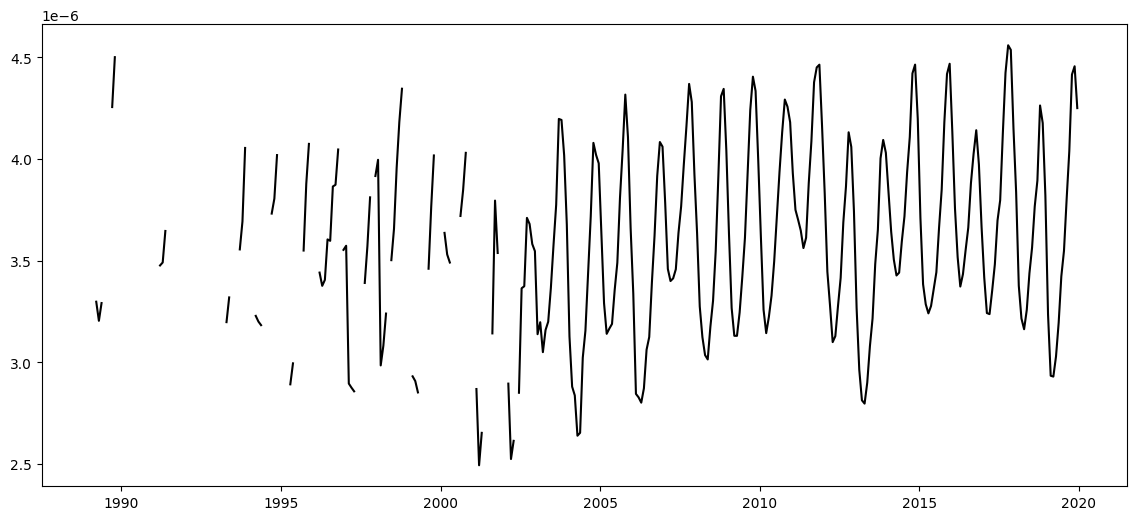

In [40]:
plt.figure(figsize=(14,6))
plt.plot(np.arange(1985,2020,1/12.)+1/24., h2o30_cci,color='k', label='H2O unfilled')
plt.show()

## Data transformation
As we see in the plot of the ESA CCI data we are in the realm of e^-6. This should be fixed for actually working with the data. Thus this section transforms the data into the realm [0,10] for comparison to the results of Nowack et al. (2023)

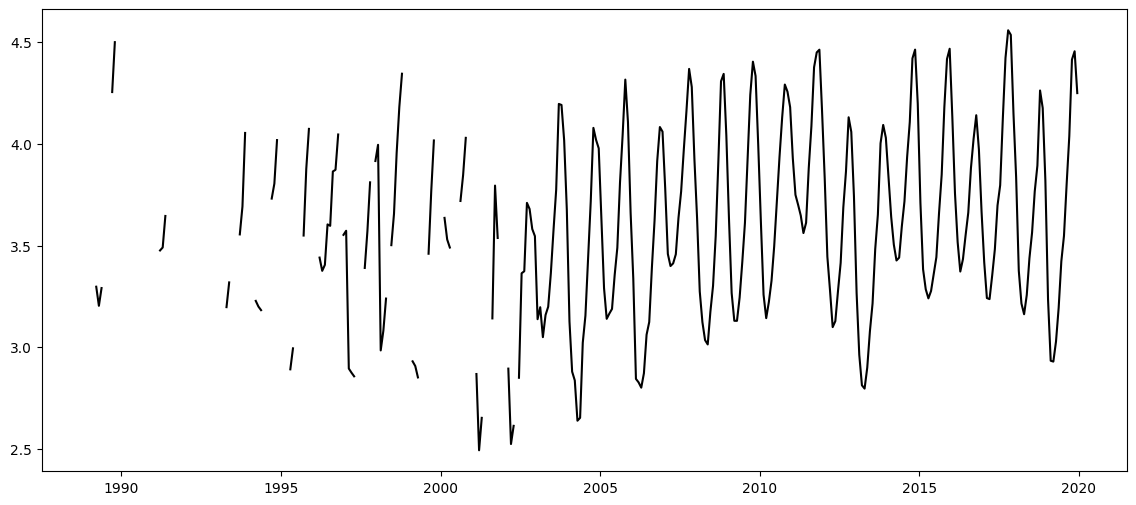

In [41]:
for i in range(len(h2o30_cci)):
    h2o30_cci[i] = h2o30_cci[i] * 1e6

## Plot it again
plt.figure(figsize=(14,6))
plt.plot(np.arange(1985,2020,1/12.)+1/24., h2o30_cci,color='k', label='H2O unfilled')
plt.show()

## Export Dataset as timeseries
We have now successfully created the dataset. To use it in the ridge regression, we now want to export the dataset, so that we may use it in the ridge regression. For this we need to export the file into our data folder

In [48]:
timeyr = np.arange(1985,2020,1/12.)+1/24.

Nt = len(timeyr)
sampindex = np.arange(0,len(h2o30_cci),1)
output = netCDF4.Dataset('../data/timeseries/esa_cci_timeseries.nc', 'w')
output.createDimension('time', Nt)
output.createDimension('samples', len(h2o30_cci))

TIME = output.createVariable('time', float, ('time'), zlib=True)
SAMPIND = output.createVariable('index', float, ('samples'), zlib=True)
SAMPLES = output.createVariable('value', float, ('time','samples'), zlib=True)

TIME[:] = timeyr
SAMPIND[:] = sampindex
SAMPLES[:] = h2o30_cci

# close the .nc file
output.close()
